###  Classification Targets

Target - the target is an ordinal variable indicating groups of income levels.

1 = extreme poverty \
2 = moderate poverty \
3 = vulnerable households \
4 = non vulnerable households


https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

### ✅ Setup

Install the required packages abd declare the global variables.

In [46]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [47]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [48]:
DATA_DIR = '../data/'
TEST_CSV = DATA_DIR + 'test.csv'
TRAIN_CSV = DATA_DIR + 'train.csv'

TARGET_COLUMN = "Target"
ID_COLUMN = "Id"
HOUSE_HOLD_ID_COLUMN = "idhogar"

DEFAULT_RANDOM_STATE = 369
DEFAULT_TEST_SIZE = 0.4
DEFAULT_VALIDATION_SIZE = 0.4
DEFAULT_CROSS_VALIDATION = 5

### ✅ Visualization

In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize
from sklearn.metrics import precision_recall_curve


VIS_TARGET_LABELS = ['1', '2', '3', '4']

def fancy_metric_vis(model, X_test, y_test, xgb_encoder = None):
    n_classes = 4
    fig, ax = plt.subplots(1, 3, figsize=(16, 6))
    fig.suptitle('Model Metrics')

    plot_confusion_matrix(model, X_test, y_test, ax=ax[0], xgb_encoder = xgb_encoder)
    plot_roc_curve(model, X_test, y_test, n_classes, ax=ax[1])
    plot_pr_curve(model, X_test, y_test, n_classes, ax=ax[2])

    plt.tight_layout()
    plt.show() 

def plot_confusion_matrix(model, test_x, test_y, ax, xgb_encoder = None):
    predictions = model.predict(test_x)
    predictions = xgb_encoder.inverse_transform(predictions) if xgb_encoder else predictions
    cm = confusion_matrix(test_y, predictions)
    ax.set_title('Confusion Matrix')

    class_labels = VIS_TARGET_LABELS
    ax.set_xticks(np.arange(len(class_labels)))
    ax.set_xticklabels(class_labels)
    ax.set_yticks(np.arange(len(class_labels)))
    ax.set_yticklabels(class_labels)
      
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ConfusionMatrixDisplay(cm, display_labels=class_labels).plot(ax=ax, cmap=plt.cm.Blues)
    
def plot_pr_curve(model, test_x, test_y, n_classes, ax):
    class_labels = ['1', '2', '3', '4']
    test_y_bin = label_binarize(test_y, classes=[1, 2, 3, 4])
    predictions = model.predict_proba(test_x)
    precision = dict()
    recall = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(test_y_bin[:, i], predictions[:, i])
        ax.plot(recall[i], precision[i], lw=2, label=VIS_TARGET_LABELS[i])

    ax.set_xlabel('Recall')
    ax.set_ylabel('Precision')
    ax.legend(loc="best")
    ax.set_title('PR Curve')

def plot_roc_curve(model, test_x, test_y, n_classes, ax):
    test_y_bin = label_binarize(test_y, classes=[1, 2, 3, 4])
    predictions = model.predict_proba(test_x)
    fpr = dict()
    tpr = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(test_y_bin[:, i], predictions[:, i])
        ax.plot(fpr[i], tpr[i], lw=2, label=VIS_TARGET_LABELS[i])

    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc="best")
    ax.set_title('ROC Curve')

### ✅ Data Overview

In [50]:
csv_data = pd.read_csv(TRAIN_CSV)
csv_data.describe(include = 'all')

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,9557,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
unique,9557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_279628684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,NaN,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,NaN,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,NaN,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,NaN,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,NaN,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000


In [51]:
print(f"Total number of rows: {len(csv_data)}")

Total number of rows: 9557


In [52]:
csv_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Text(0.5, 1.0, 'Histogram of People by Class')

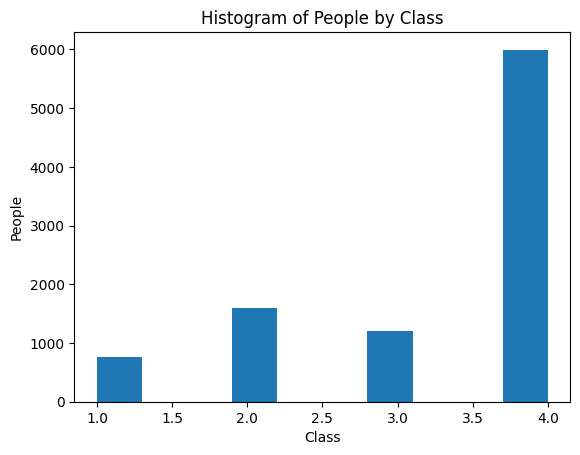

In [53]:
ax = csv_data[TARGET_COLUMN].hist()
ax.grid(False) 
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('Histogram of People by Class')

### ✅  Data Preparation

The data preparation will:
- Remove unnecessary columns (ID, Target, idhogar)
- Fill missing values with the median. Because the data is skewed, the median is a better choice than the mean.
- Encode categorical variables

> Note: *idhogar* is a unique identifier for each household.

To prepare the data we use `Pipeline` and `ColumnTransformer` from `sklearn`. It is possible to combine the estimator and the transformer in a single pipeline, but we will keep the data preparation and the model training separate as we will use the same data preparation for all models.

In [54]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy

pipeline = None

def fill_and_encode(data, fit=False):
    global pipeline
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = data.select_dtypes(include=['object', 'bool']).columns  

    num_transformer = SimpleImputer(strategy='median') 

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
        ])

    if pipeline is None or fit:
        pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
        fit_data = pipeline.fit_transform(data)
    else:
        fit_data = pipeline.transform(data)

    feature_names = num_cols
    return pd.DataFrame(fit_data, columns = feature_names)

def map_string_to_int(data):
    mapping = {"yes": 1, "no": 0, "": 0}
    # For the following fields the values 0,1 are represented as yes,no. odd!
    # edjefe,years of education of male head of household
    # edjefa,years of education of female head of household
    # dependency, Dependency rate
    for col in ["edjefe", "edjefa", 'dependency']:
        data[col] = data[col].apply(lambda x: mapping[x] if x in mapping else x).astype(float)
    return data

def remove_columns(data):
    AGE_SQUARE = 'SQBage'
    HOUSEHOlD_SIZE = 'tamhog'
    cols_to_remove = [ ID_COLUMN, TARGET_COLUMN, HOUSE_HOLD_ID_COLUMN, AGE_SQUARE, HOUSEHOlD_SIZE ]
    for col in cols_to_remove:
        if col in data.columns:
            data = data.drop(columns = col)
    return data

def prepare(csv_path = None, data = None):
    if csv_path is None and data is None:
        raise ValueError("Either csv_path or data must be provided")
    if csv_path is not None and data is not None:
        raise ValueError("Only one of csv_path or data must be provided")
    raw_data = pd.read_csv(csv_path) if csv_path is not None else deepcopy(data)
    raw_data = remove_columns(raw_data)
    raw_data = map_string_to_int(raw_data)
    return fill_and_encode(raw_data)

In [55]:
csv_data.shape

(9557, 143)

In [56]:
TARGET = csv_data[TARGET_COLUMN]
DATA = prepare(data=csv_data)
TRAINING_FEATURES = DATA.columns
print(f"TARGET: {TARGET.shape} | DATA: {DATA.shape}")

TARGET: (9557,) | DATA: (9557, 138)


In [57]:
DATA.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,area2,age,SQBescolari,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq
0,190000.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,43.0,100.0,1.0,100.0,0.0,1.000000,0.0,100.0,1849.0
1,135000.0,0.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,67.0,144.0,1.0,144.0,0.0,1.000000,64.0,144.0,4489.0
2,130000.0,0.0,8.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,92.0,121.0,1.0,0.0,0.0,0.250000,64.0,121.0,8464.0
3,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,17.0,81.0,16.0,121.0,4.0,1.777778,1.0,121.0,289.0
4,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,37.0,121.0,16.0,121.0,4.0,1.777778,1.0,121.0,1369.0


In [58]:
X_train, X_test, y_train, y_test = train_test_split(DATA, TARGET, test_size=DEFAULT_TEST_SIZE, random_state=DEFAULT_RANDOM_STATE)

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((5734, 138), (5734,), (3823, 138), (3823,))

### ✅ Sampling

The training data is imbalanced. There is sinnificantly higher number of data for class 4 than the other classes. This will be addressed by experimenting with different sampling. The oversampling will be done only on the training data. The test data will remain unchanged.

- **Oversampling:** will increase the number of data for the minority classes. For this we use the `RandomOverSampler` from the `imblearn` library.

- **Undersampling:** will decrease the number of data for the majority classes. For this we use the `RandomUnderSampler` from the `imblearn` library.

- **Over and Under Sampling** will increase the number of data for the minority classes and decrease the number of data for the majority classes. For this we use the `SMOTETomek` from the `imblearn` library.


In [60]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

def oversample(X, y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, y)

def undersample(X, y):
    ros = RandomUnderSampler(random_state=0)
    return ros.fit_resample(X, y)

def smotsample(X, y):
    ros = SMOTETomek(sampling_strategy='auto')
    return ros.fit_resample(X, y)

Text(0.5, 1.0, 'People by Class (oversampled)')

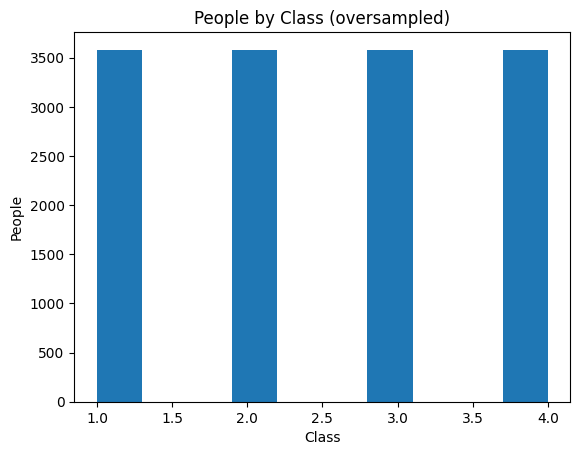

In [61]:
oversampled_X, oversampled_y = oversample(X_train, y_train)
ax = oversampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (oversampled)')

Text(0.5, 1.0, 'People by Class (undersampled)')

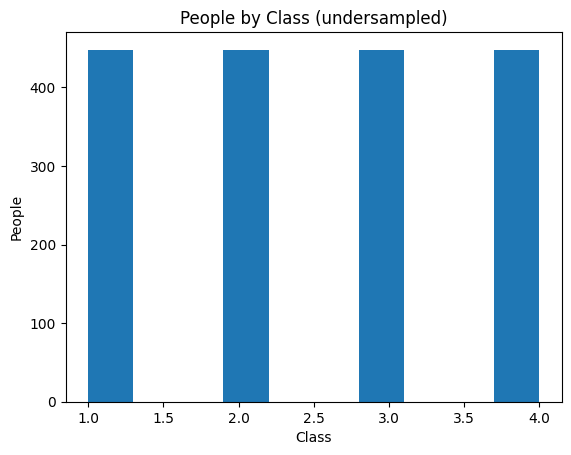

In [62]:
undersampled_X, undersampled_y = undersample(X_train, y_train)
ax = undersampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (undersampled)')

Text(0.5, 1.0, 'People by Class (smotsampled)')

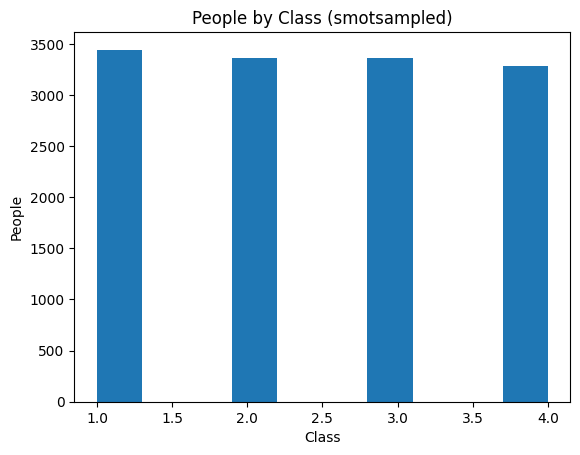

In [63]:
smotsampled_X, smotsampled_y = smotsample(X_train, y_train)
ax = smotsampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (smotsampled)')

### ✅ Ensemble learning

#### ✅ Shared Code

We would like to experiment with different models and different configuration and different hyperparameters. To ease the process and avoid code duplication we use reusable functions for:

- **Model training** 
- **Model evaluation**
- **Visualization**
- **Important features**

In the training the model we use `GridSearchCV` for hyperparameter tuning. The `GridSearchCV` will use weighted F1 score as the scoring function. The `GridSearchCV` will use 5-fold cross validation by default.

> Note: for `XGBoost` always transform the prediction using the encoder.

In [64]:
from enum import Enum

class SearchingMethod(Enum):
    GRID = 1
    RANDOM = 2
    HALVING = 3

In [65]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV

def prepare_model(
    model, 
    train_x, 
    train_y, 
    param_grid = None, 
    boosting = 'not-xgb',
    encoder = None,
    test_size=DEFAULT_VALIDATION_SIZE, 
    cv = DEFAULT_CROSS_VALIDATION):
    if boosting == 'xgb' and encoder is None:
        raise ValueError("encoder must be provided for xgb boosting")

    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=test_size, random_state=DEFAULT_RANDOM_STATE, stratify=train_y)

    if param_grid is not None:
        # model = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)
        model = GridSearchCV(model, param_grid, cv=cv, scoring="f1_macro", n_jobs=-1)

    model.fit(X_train, y_train if boosting != 'xgb' else encoder.fit_transform(y_train))
    
    predictions = model.predict(X_test)
    predictions = predictions if boosting != 'xgb' else encoder.inverse_transform(predictions)

    return model

def train_model(
    model, 
    train_x, 
    train_y, 
    param_grid = None, 
    boosting = 'not-xgb',
    encoder = None,
    test_size=DEFAULT_VALIDATION_SIZE, 
    cv = DEFAULT_CROSS_VALIDATION,
    scoring = 'f1_macro',
    search = SearchingMethod.HALVING):

    if boosting == 'xgb' and encoder is None:
        raise ValueError("encoder must be provided for xgb boosting")

    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=test_size, random_state=DEFAULT_RANDOM_STATE, stratify=train_y)

    if param_grid is not None:
        if search == SearchingMethod.HALVING:
            model = HalvingGridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
        elif search == SearchingMethod.RANDOM:
            model = HalvingRandomSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)
        else:
            model = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1)

    model.fit(X_train, y_train if boosting != 'xgb' else encoder.fit_transform(y_train))
    
    predictions = model.predict(X_test)
    predictions = predictions if boosting != 'xgb' else encoder.inverse_transform(predictions)
    accuracy = accuracy_score(y_test, predictions)

    best_params = model.best_params_ if param_grid is not None else None
    cv_results = model.cv_results_ if param_grid is not None else None

    return model, accuracy, best_params, cv_results


def important_features(trained_model):
    columns = TRAINING_FEATURES
    trained_model = trained_model.best_estimator_
    return pd.DataFrame(trained_model.feature_importances_,
                                index = columns,
                                columns=['importance']).sort_values('importance', ascending=False)

#### ✅ AdaBoost

In [66]:
ada_boost_param_grid = {
    # run this when you have time
    'learning_rate': [0.01, 0.05, 0.25, 0.5, 1],
    'estimator__max_depth': [2 , 3, 5, 7, 10],
    'estimator__min_samples_leaf': [3, 5, 10, 20]

    # 'learning_rate': [0.01],
    # 'estimator__max_depth': [3],
    # 'estimator__min_samples_leaf': [5]
}

best_param = {'estimator__max_depth': [10], 'estimator__min_samples_leaf': [5], 'learning_rate': [0.5]}
ada_boost_param_grid = best_param

ada_result = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), oversampled_X, oversampled_y, param_grid=ada_boost_param_grid)
ada_boost_model, training_accuracy = ada_result[0], ada_result[1]
print(f"Best parameters: \n{ada_boost_model.best_params_}")
print(f"AdaBoost training accuracy: {training_accuracy}")

Best parameters: 
{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.5}
AdaBoost training accuracy: 0.9846422338568935


In [67]:
pd.DataFrame(ada_boost_model.cv_results_)

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_leaf,param_learning_rate,params,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,8594,7.792564,0.058086,0.080175,0.001927,10,5,0.5,"{'estimator__max_depth': 10, 'estimator__min_s...",...,0.965671,0.003114,1,1.0,1.0,0.999709,0.999855,1.0,0.999913,0.000116


In [68]:
important_features(ada_boost_model).head(20)

,importance
energcocinar3,0.097932
pisomoscer,0.071721
epared2,0.060482
edjefa,0.058551
energcocinar2,0.051232
qmobilephone,0.048481
hogar_adul,0.046329
r4m1,0.038518
rooms,0.035099
r4h2,0.031290


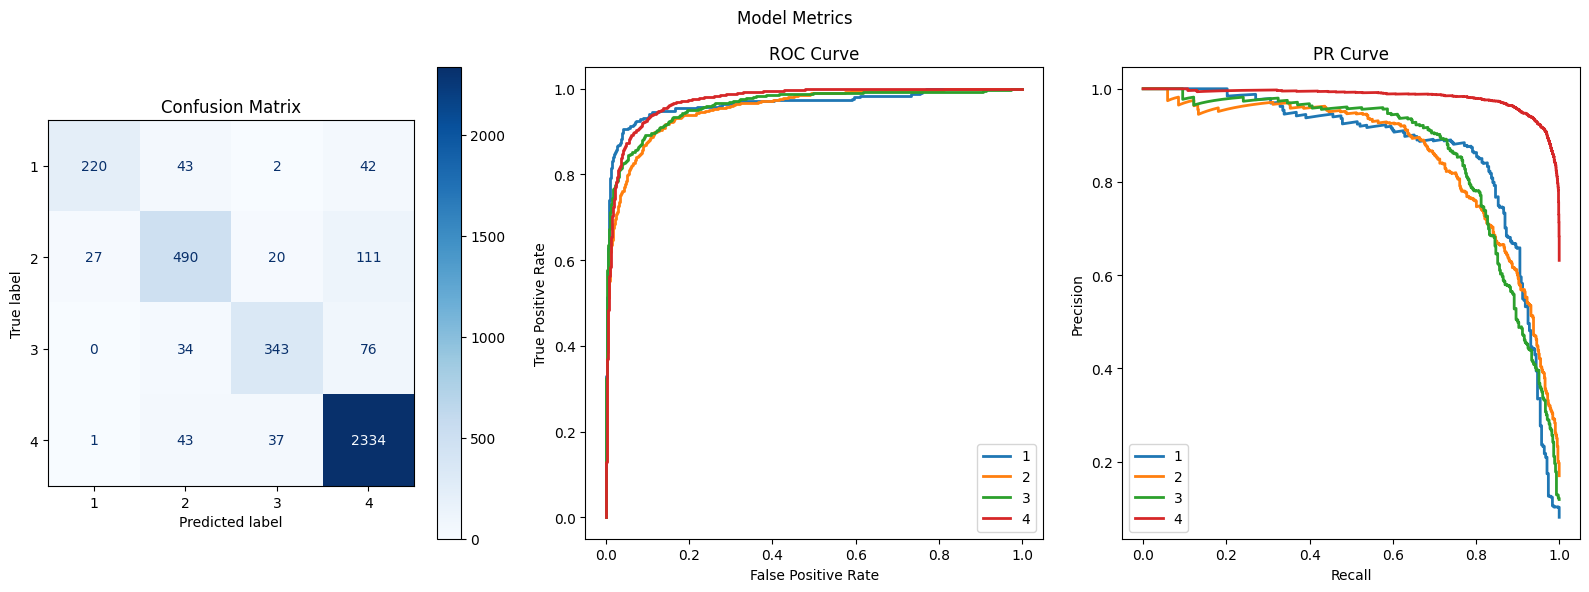

In [69]:
fancy_metric_vis(ada_boost_model, X_test, y_test)

In [70]:
best_param = {'estimator__max_depth': [10], 'estimator__min_samples_leaf': [5], 'learning_rate': [0.5]}
ada_boost_param_grid = best_param

under_ada, training_accuracy = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), undersampled_X, undersampled_y, param_grid=ada_boost_param_grid)
print(f"Training accuracy: {training_accuracy}")

ValueError: too many values to unpack (expected 2)

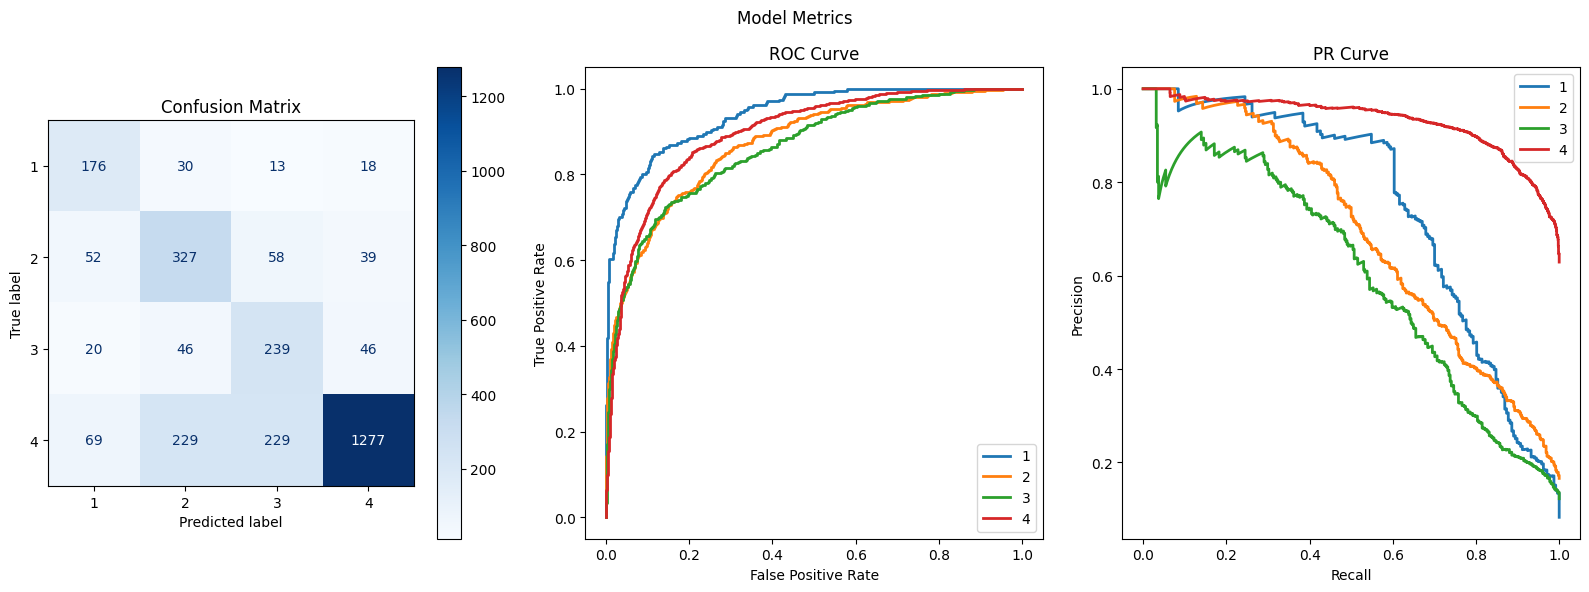

In [ ]:
fancy_metric_vis(under_ada, X_test, y_test)

In [ ]:
best_param = {'estimator__max_depth': [10], 'estimator__min_samples_leaf': [5], 'learning_rate': [0.5]}
ada_boost_param_grid = best_param

overunder_ada = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), smotsampled_X, smotsampled_y, param_grid=ada_boost_param_grid)
overunder_ada, training_accuracy = overunder_ada[0], overunder_ada[1]
print(f"Training accuracy: {training_accuracy}")


Training accuracy: 0.9329268292682927


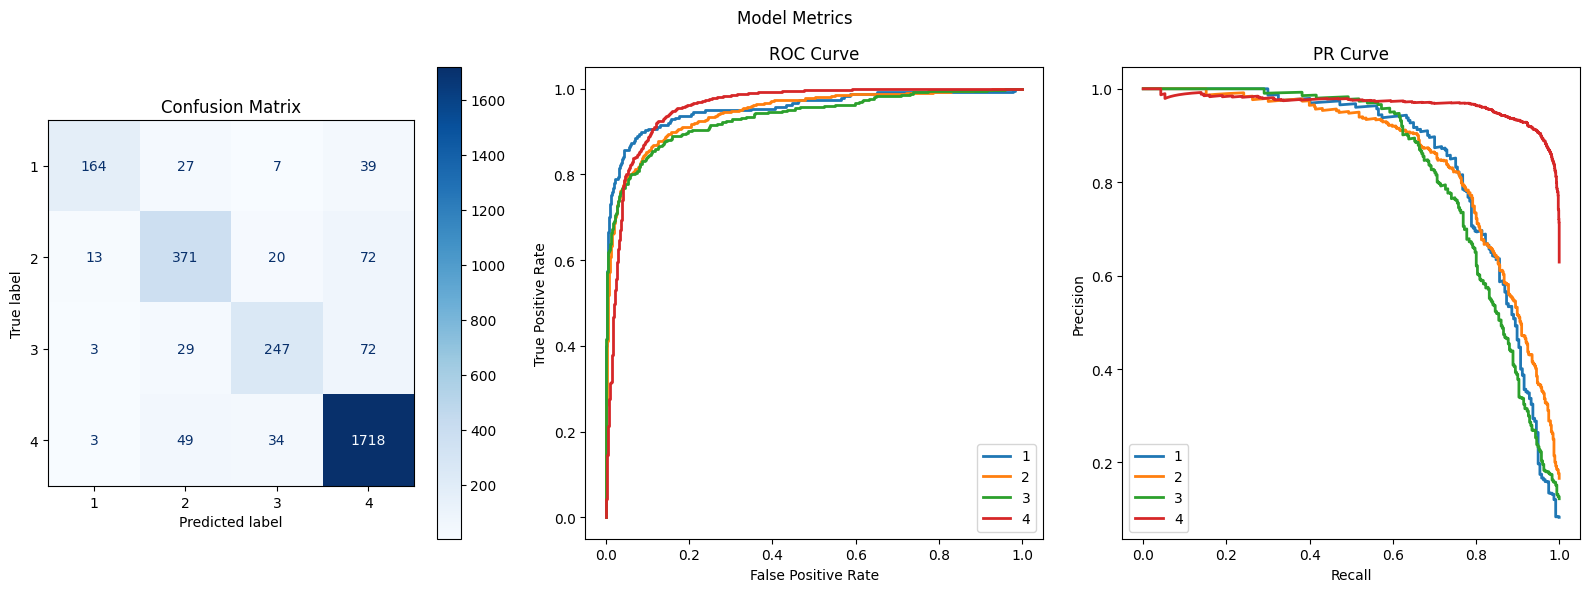

In [ ]:
fancy_metric_vis(overunder_ada, X_test, y_test)

#### ✅ Gradient Boosting

In [ ]:
gradient_boost_param_grid = {
    # Run this at before going to sleep
    'learning_rate': [0.01, 0.05, 0.1, 0.2125, 0.5],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20],
    'n_estimators': [100, 200, 300, 400, 500],
    
    # 'learning_rate': [0.1],
    # 'max_depth': [3],
    # 'min_samples_leaf': [5]
}

best_gparam = {'n_estimators': [300], 'min_samples_leaf': [5], 'max_depth': [10], 'learning_rate': [0.5]}
gradient_boost_param_grid = best_gparam

gb_result = train_model(GradientBoostingClassifier(), oversampled_X, oversampled_y, param_grid=gradient_boost_param_grid, search=SearchingMethod.GRID)
gradient_boost_model, training_accuracy = gb_result[0], gb_result[1]
print(f"Best parameters: \n{gradient_boost_model.best_params_}")
print(f"GradientBoost training accuracy: {training_accuracy}")

Best parameters: 
{'learning_rate': 0.5, 'max_depth': 10, 'min_samples_leaf': 5, 'n_estimators': 300}
GradientBoost training accuracy: 0.9896640826873385


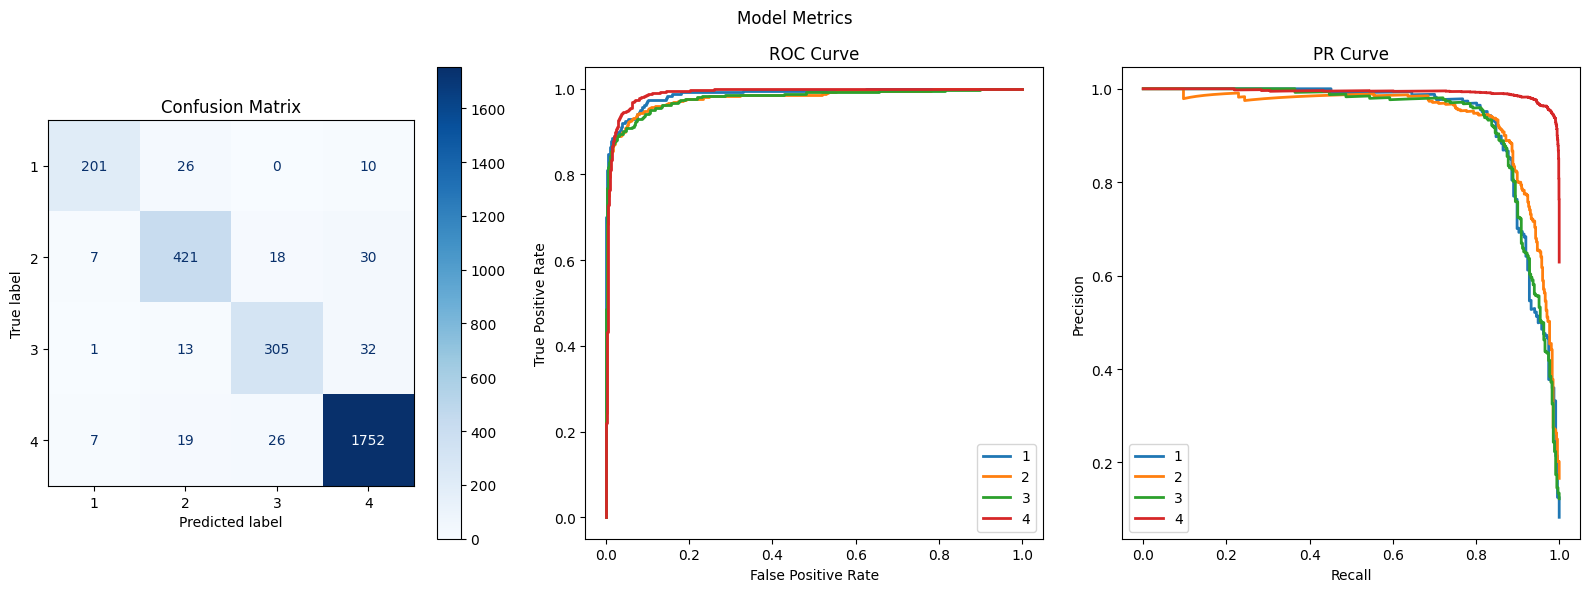

In [ ]:
fancy_metric_vis(gradient_boost_model, X_test, y_test)

In [ ]:
important_features(gradient_boost_model).head(20)

,importance
SQBmeaned,0.074794
SQBdependency,0.058780
meaneduc,0.058676
SQBedjefe,0.055073
qmobilephone,0.047599
v2a1,0.036863
r4t1,0.029507
rooms,0.028802
overcrowding,0.020920
r4t2,0.020856


#### ✅ XGBoost

Sofar the best hyperparameter for xgboost are:

```python
{'objective': ['multi:logistic'], 'num_class': [4], 'n_estimators': [100], 'max_depth': [10], 'learning_rate': [0.1], 'eval_metric': ['merror']}
```

Best parameter with f1_macro:
```python
{'eval_metric': 'merror', 'learning_rate': 1, 'max_depth': 10, 'n_estimators': 100, 'num_class': 4, 'objective': 'multi:softprob'}
```

In [83]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

xgb_param_grid = {
    # Run this at before going to sleep
    'n_estimators': [100, 200, 300],
    'max_depth': [2, 5, 10, 15, 20],
    'learning_rate': [0.01, 0.4, 0.06, 0.1, 0.2, 0.5, 1],
    'objective': ['multi:softmax', 'multi:softprob', 'multi:logistic'],
    'num_class': [4],
    'eval_metric': ['merror', 'mlogloss' ],

    # 'n_estimators': [1000],
    # 'learning_rate': [0.1],
    # 'objective': ['multi:softmax'],
    # 'num_class': [4],
    # 'eval_metric': ['merror'],
}


xgb_result = train_model(
    XGBClassifier(), 
    smotsampled_X, 
    smotsampled_y, 
    param_grid=xgb_param_grid, 
    boosting='xgb', 
    encoder=le,
    scoring='f1_weighted',
    search=SearchingMethod.RANDOM
)
xgb_model, training_accuracy = xgb_result[0], xgb_result[1]
print(f"Best parameters: \n{xgb_model.best_params_}")
print(f"XGBoost training accuracy: {training_accuracy}")

Best parameters: 
{'objective': 'multi:logistic', 'num_class': 4, 'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.4, 'eval_metric': 'merror'}
XGBoost training accuracy: 0.8347276445435955


In [84]:
xgb_result[2]

{'objective': 'multi:logistic',
 'num_class': 4,
 'n_estimators': 300,
 'max_depth': 2,
 'learning_rate': 0.4,
 'eval_metric': 'merror'}

In [85]:
pd.DataFrame(xgb_result[3])

,iter,n_resources,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_num_class,param_n_estimators,param_max_depth,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0,40,0.731391,0.022102,0.065497,0.007720,multi:softmax,4,300,2,...,0.311207,0.092505,295,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
1,0,40,0.721735,0.133100,0.059178,0.022391,multi:softprob,4,300,20,...,0.361854,0.081707,240,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
2,0,40,0.194315,0.026148,0.032080,0.004973,multi:softprob,4,100,15,...,0.361854,0.081707,240,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
3,0,40,0.326291,0.032693,0.036578,0.005275,multi:softmax,4,200,5,...,0.363520,0.081618,176,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
4,0,40,0.328516,0.007125,0.040688,0.010032,multi:logistic,4,200,5,...,0.363520,0.081618,176,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,3,1080,5.699388,0.244202,0.041501,0.011061,multi:logistic,4,100,5,...,0.643229,0.035753,9,0.988420,0.991882,0.995385,0.993061,0.990715,0.991893,0.002324
298,3,1080,5.185430,0.106372,0.023411,0.002897,multi:softprob,4,100,5,...,0.643229,0.035753,9,0.988420,0.991882,0.995385,0.993061,0.990715,0.991893,0.002324
299,4,3240,6.481752,0.040100,0.051474,0.002808,multi:logistic,4,300,2,...,0.759323,0.006499,1,0.979559,0.978052,0.982275,0.984629,0.975746,0.980052,0.003120
300,4,3240,4.444127,0.186119,0.060353,0.036858,multi:softprob,4,200,2,...,0.700729,0.004852,2,0.872330,0.877368,0.870507,0.880079,0.870557,0.874168,0.003873


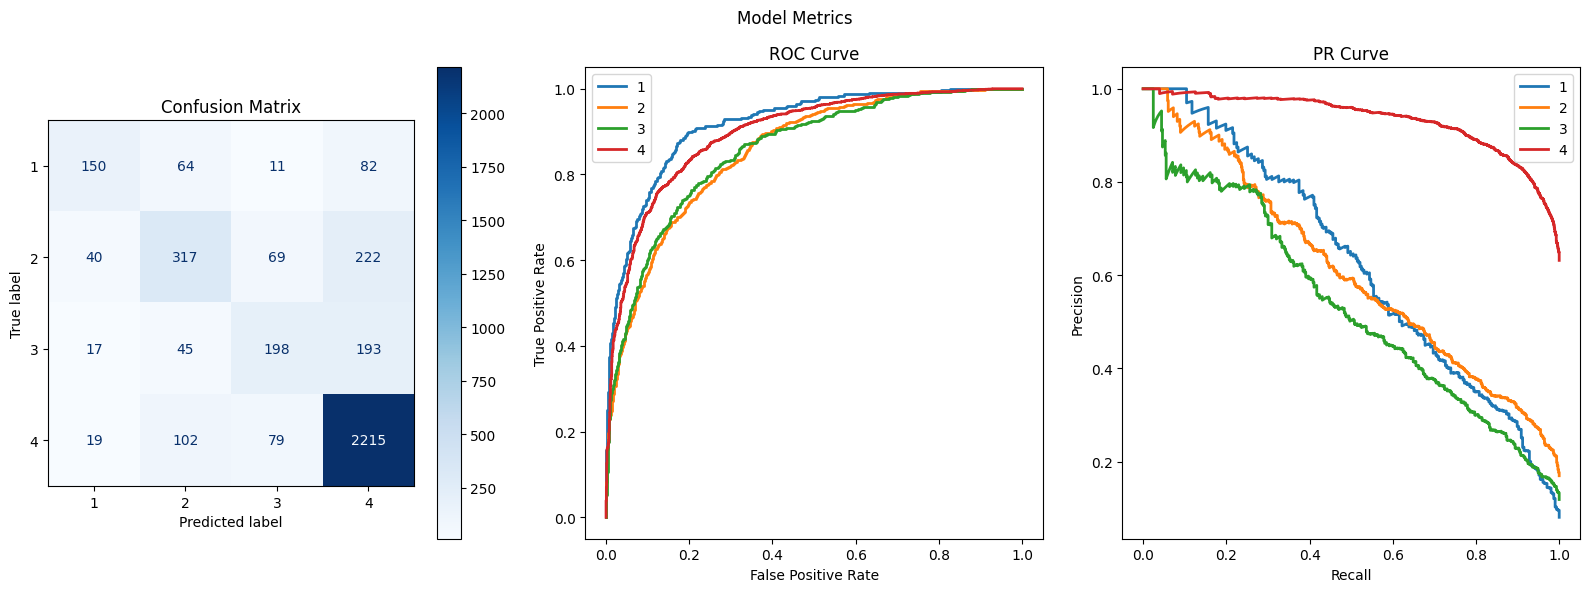

In [86]:
fancy_metric_vis(xgb_model, X_test, y_test, xgb_encoder=le)

In [77]:
important_features(xgb_model).head(20)

,importance
parentesco10,0.079049
techozinc,0.041256
abastaguano,0.040600
sanitario6,0.035462
techocane,0.033840
parentesco4,0.031665
epared3,0.027488
pisonatur,0.027231
v18q,0.025624
sanitario1,0.020335


#### ✅ Bagging

Best parameters by far:
```python
{'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.75, 'n_estimators': 500}
``` 


In [78]:
from sklearn.ensemble import BaggingClassifier

bagging_param_grid = {
    'n_estimators': [10, 50, 100, 200, 500],
    'max_samples': [0.1, 0.25, 0.5, 0.75, 1.0],
    'max_features': [0.1, 0.25, 0.5, 0.75, 1.0],
    'bootstrap': [True, False],
    'bootstrap_features': [True, False],

    # 'n_estimators': [500],
    # 'max_samples': [0.75],
    # 'max_features': [0.5],
    # 'bootstrap': [True],
    # 'bootstrap_features': [True]
}

# best_bagging_param = {'n_estimators': [500], 'max_samples': [0.75], 'max_features': [0.5], 'bootstrap': [True], 'bootstrap_features': [True]}
# bagging_param_grid = best_bagging_param

bagging_result = train_model(BaggingClassifier(), oversampled_X, oversampled_y, param_grid=bagging_param_grid)
bagging_model, training_accuracy = bagging_result[0], bagging_result[1]
print(f"Best parameters: \n{bagging_model.best_params_}")
print(f"Bagging training accuracy: {training_accuracy}")

Best parameters: 
{'bootstrap': False, 'bootstrap_features': False, 'max_features': 0.25, 'max_samples': 1.0, 'n_estimators': 500}
Bagging training accuracy: 0.9891797556719023


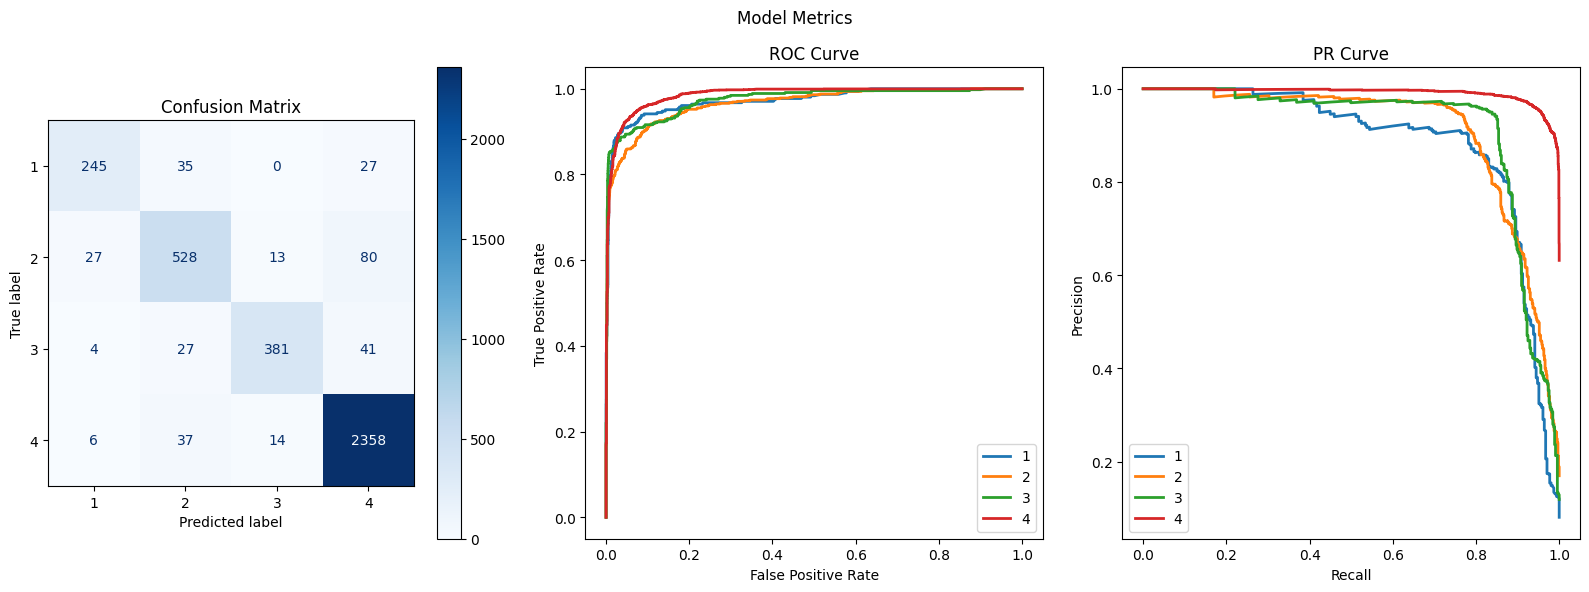

In [79]:
fancy_metric_vis(bagging_model, X_test, y_test)

#### ✅ Stacking

93

In [82]:
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

stacking_param_grid = {}

ada_boost = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=10, min_samples_leaf=5), learning_rate=0.5)
gradient_boost = GradientBoostingClassifier(n_estimators=300, min_samples_leaf=5, max_depth=10, learning_rate=0.5)
xgb_boost = XGBClassifier(objective='multi:logistic', num_class=4, n_estimators=100, max_depth=10, learning_rate=0.1, eval_metric='merror')
stacking_clf = StackingClassifier(
    estimators=[('ada', AdaBoostClassifier(estimator=DecisionTreeClassifier())), 
                ('gb', GradientBoostingClassifier()), 
                ('xgb', XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss')), 
                ('bagging', BaggingClassifier())],
    final_estimator=GradientBoostingClassifier()
)

stacking_clf = StackingClassifier(
    estimators=[('ada', ada_boost), 
                ('gb', gradient_boost), 
                ('xgb', xgb_boost), 
                ('bagging', BaggingClassifier())],
    final_estimator=GradientBoostingClassifier()
)
stacking_result = train_model(stacking_clf, smotsampled_X, smotsampled_y, param_grid=stacking_param_grid)
stacking_model, training_accuracy = stacking_result[0], stacking_result[1]
print(f"Best parameters: \n{stacking_model.best_params_}")
print(f"Stacking training accuracy: {training_accuracy}")

Best parameters: 
{}
Stacking training accuracy: 0.9505484290760364


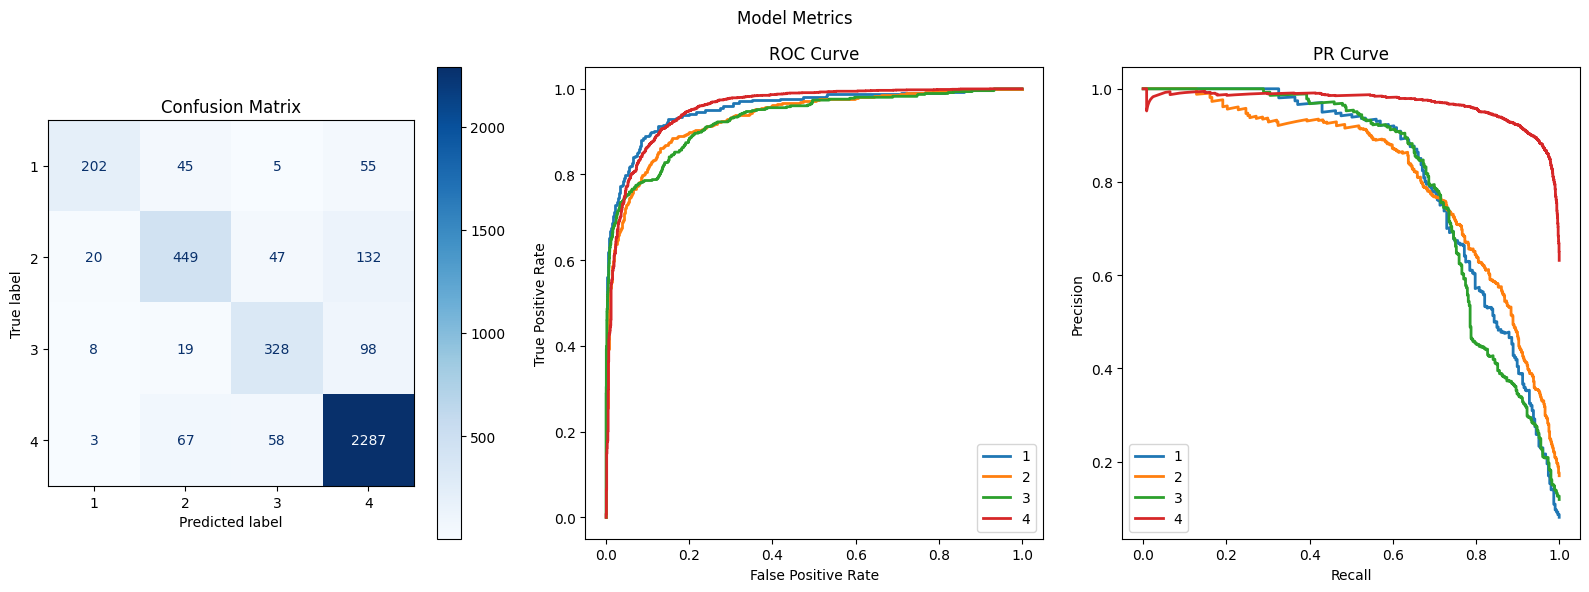

In [81]:
fancy_metric_vis(stacking_model, X_test, y_test)

## Tasks
- ✅ A working setup for Ensemble learning with AdaBoost, Gradient Boosting and XGBoost
- ✅ Feature importance for the different models
- ✅ Compare the different models accuracy
- ✅ Add different data preprocessing methods
- ✅ Balance dataset by undersampling, and possibly oversampling

- ✅ Test all models with different sampling methods
- ✅ Find optimum parameter for the different models
- ✅ Performance Metric
- ❌ Experiment with heterogeneous ensemble with simple CNN